<a href="https://colab.research.google.com/github/TAUforPython/BioMedAI/blob/dev/GNN%20model%20ECG%20classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset prepare

In [ ]:
!pip install --quiet --upgrade gensim
import os
os.kill(os.getpid(), 9)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import gensim
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_decision_regions
from gensim.models import Word2Vec

In [2]:
# загружаем полный датасет
raw_table_data = pd.read_csv('https://raw.githubusercontent.com/TAUforPython/BioMedAI/main/test_datasets/test_data_ECG.csv', nrows=5000)
raw_table_data.head(10)

,subject_id,Count_subj,study_id,cart_id,Healthy_Status,eeg_time,eeg_date,report_0,report_1,report_2,...,filtering,rr_interval,p_onset,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis
0,19557662,27,40000017,6848296,0,8:44 AM,27.06.2015,Sinus rhythm,Possible right atrial abnormality,NaN,...,60 Hz notch Baseline filter,659,40,128,170,258,518,81,77,79
1,18477137,93,40000029,6848296,0,9:54 AM,27.06.2015,Sinus rhythm,Possible right atrial abnormality,NaN,...,60 Hz notch Baseline filter,722,40,124,162,246,504,77,75,70
2,16598616,3,40000035,6376932,1,9:07 AM,28.06.2015,Sinus tachycardia,NaN,Normal ECG except for rate,...,60 Hz notch Baseline filter,600,40,130,162,244,474,79,72,77
3,16368287,7,40000079,6214760,1,5:14 PM,15.07.2015,Sinus rhythm,NaN,Normal ECG,...,60 Hz notch Baseline filter,659,40,146,180,254,538,79,66,69
4,18370366,2,40000084,6632385,0,1:52 PM,27.09.2015,Sinus rhythm,NaN,NaN,...,<not specified>,659,368,29999,504,590,868,84,80,77
5,15606157,55,40000089,6632385,0,2:29 PM,29.10.2013,Sinus rhythm,NaN,NaN,...,<not specified>,822,365,29999,499,592,852,26,46,30
6,12576058,43,40000115,6852956,1,12:54 PM,23.03.2016,Sinus rhythm,NaN,Normal ECG,...,60 Hz notch Baseline filter,952,40,146,198,282,598,24,80,20
7,14691089,1,40000143,6551957,0,10:01 AM,10.12.2016,Sinus rhythm,rSr'(V1) - probable normal variant,Low QRS voltages in precordial leads,...,60 Hz notch Baseline filter,923,40,140,188,278,594,26,86,13
8,14144725,7,40000144,6924910,0,7:24 AM,11.12.2011,Sinus rhythm with PAC(s).,NaN,Borderline ECG,...,60 Hz notch Baseline filter,952,40,180,196,294,610,59,-17,3
9,16089780,2,40000152,6919786,0,12:35 PM,13.12.2011,Sinus rhythm,Extensive T wave changes may be due to myocard...,NaN,...,60 Hz notch Baseline filter,1000,40,156,178,274,584,8,-11,19


In [7]:
# Предобрабатываем данные словестных репортов word2vec в числовой вектор

# Убираем выбросы
columns_to_filter = ['rr_interval', 'p_onset', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis']
full_df_filtered = raw_table_data[(raw_table_data[columns_to_filter] < 2000).all(axis=1)]
full_df_filtered = full_df_filtered[(full_df_filtered['p_onset'] < full_df_filtered['p_end']) & (full_df_filtered['qrs_onset'] < full_df_filtered['qrs_end'])]

# Слепляем все текстовые отчеты в один большой
reports = [f'report_{x}' for x in range(18)]
full_df_filtered['report_0'] = full_df_filtered[reports].astype(str).agg(' '.join, axis=1)
full_df_filtered['report_0'] = full_df_filtered['report_0'].str.replace(r'\bnan\b', '', regex=True).str.replace(r'\s+', ' ', regex=True).str.strip()
full_df_filtered.rename(columns={'report_0': 'report'}, inplace=True)
reports_to_drop = [f'report_{x}' for x in range(1, 18)]
full_df_filtered = full_df_filtered.drop(reports_to_drop, axis=1)

# Фиксим имена столбцов
full_df_filtered = full_df_filtered.rename(columns={'eeg_time ': 'eeg_time', 'eeg_date ': 'eeg_date'})
full_df_filtered = full_df_filtered.drop(columns = ['bandwidth', 'filtering'])

# Делаем колонку с таргетами крайней справа
full_df_filtered = full_df_filtered[[col for col in full_df_filtered.columns if col != 'Healthy_Status'] + ['Healthy_Status']]

# Разбиваем столбец с текстовым отчетом на токены
words = [text.split() for text in full_df_filtered['report']]

# Обучаем модель Word2Vec
w2v_model = Word2Vec(words)

# Функция для получения среднего эмбеддинга строки
def get_sentence_embedding(sentence):
    words = sentence.split()
    word_vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)  # Усреднённый вектор
    else:
        return np.zeros(w2v_model.vector_size)  # Нулевой вектор, если слова нет в модели

# Применяем функцию ко всей колонке и переводим каждый вектор в одно число
full_df_filtered['report'] = full_df_filtered['report'].apply(lambda x: get_sentence_embedding(x).mean())

full_df_filtered.head()

,subject_id,Count_subj,study_id,cart_id,eeg_time,eeg_date,report,rr_interval,p_onset,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,Healthy_Status
0,19557662,27,40000017,6848296,8:44 AM,27.06.2015,0.014136,659,40,128,170,258,518,81,77,79,0
1,18477137,93,40000029,6848296,9:54 AM,27.06.2015,0.014136,722,40,124,162,246,504,77,75,70,0
2,16598616,3,40000035,6376932,9:07 AM,28.06.2015,0.035067,600,40,130,162,244,474,79,72,77,1
3,16368287,7,40000079,6214760,5:14 PM,15.07.2015,0.022594,659,40,146,180,254,538,79,66,69,1
6,12576058,43,40000115,6852956,12:54 PM,23.03.2016,0.022594,952,40,146,198,282,598,24,80,20,1


In [108]:

# make new dataset from old columns
table_data = full_df_filtered[['subject_id','study_id','eeg_date','report','rr_interval','p_end','qrs_onset','qrs_end','t_end','p_axis','qrs_axis','t_axis','Healthy_Status']].copy()
table_data['eeg_date'] = pd.to_datetime(table_data['eeg_date'],dayfirst=True)
table_data = table_data.sort_values(by=['subject_id', 'eeg_date'])

table_data = table_data.head(100)

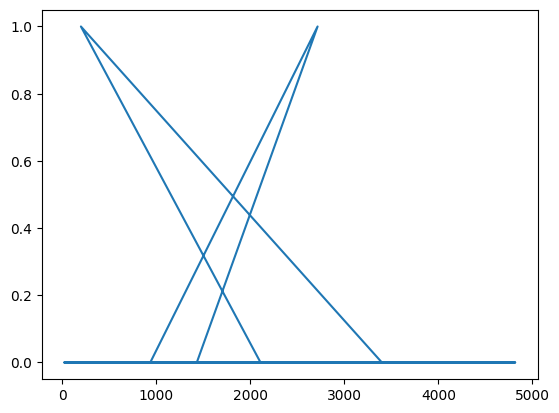

In [109]:
duplicate_index = table_data['subject_id'].duplicated()
plt.plot(duplicate_index)

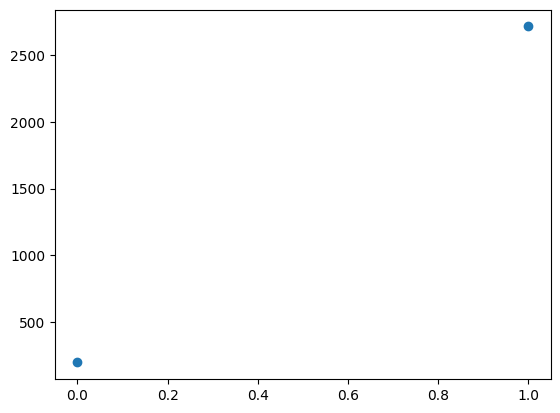

In [110]:
duplicate_index = duplicate_index[duplicate_index[:]==True].index
plt.scatter(range(0,len(duplicate_index)), duplicate_index)

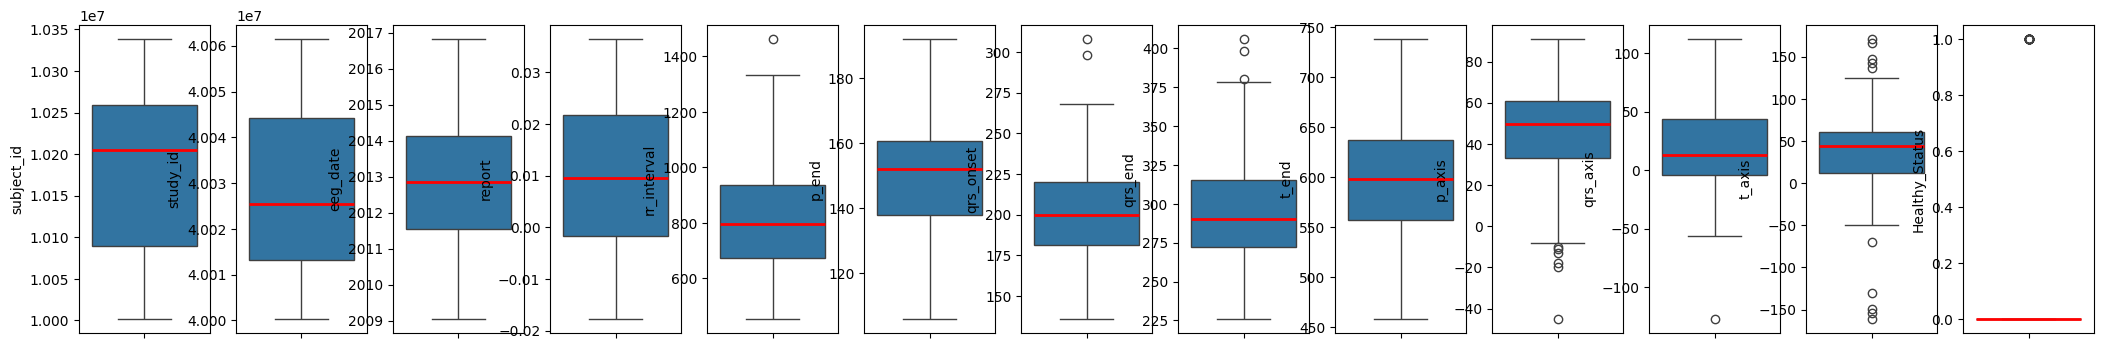

In [111]:
n = table_data.shape[1]
fig,ax = plt.subplots(1,n, figsize=(n*2,4), sharex=True)
for i in range(n):
    plt.sca(ax[i])
    col = table_data.columns[i]
    sns.boxplot(y = table_data.iloc[:,i],data=table_data, medianprops={"color": "r", "linewidth": 2})

Goldberger, A., Amaral, L., Glass, L., Hausdorff, J., Ivanov, P. C., Mark, R., ... & Stanley, H. E. (2000). PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals. Circulation [Online]. 101 (23), pp. e215–e220.

# Graph Neural Network Model

In [88]:
import os
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder

In [112]:
encoder = LabelEncoder()

In [113]:
text_columns = table_data.columns
text_columns

Index(['subject_id', 'study_id', 'eeg_date', 'report', 'rr_interval', 'p_end',
       'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis',
       'Healthy_Status'],
      dtype='object')

In [114]:
ecg_table = table_data

In [115]:
for col in text_columns:
    ecg_table[col] = encoder.fit_transform(ecg_table[col])

In [116]:
ecg_table.describe()

,subject_id,study_id,eeg_date,report,rr_interval,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,Healthy_Status
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.00000,100.000000,100.000000
mean,48.920000,49.500000,48.750000,45.670000,27.520000,19.730000,23.360000,22.920000,32.31000,32.890000,34.43000,39.040000,0.240000
std,28.385755,29.011492,28.686524,24.648255,13.560549,8.497005,11.848812,12.628075,17.63874,16.316253,18.21491,20.261881,0.429235
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000
25%,24.750000,24.750000,24.000000,24.750000,16.750000,14.000000,13.750000,13.000000,16.75000,21.000000,21.00000,23.750000,0.000000
50%,49.500000,49.500000,48.500000,48.500000,27.500000,21.000000,23.000000,22.000000,33.00000,34.500000,34.50000,41.000000,0.000000
75%,73.250000,74.250000,73.250000,72.250000,39.000000,25.250000,32.000000,31.250000,46.25000,46.000000,50.25000,56.250000,0.000000
max,97.000000,99.000000,98.000000,78.000000,51.000000,37.000000,46.000000,50.000000,64.00000,61.000000,65.00000,75.000000,1.000000


In [117]:
#ecg_table.loc[:,"report_0"] = ecg_table["report_0"].astype(str)
class_values = sorted(ecg_table["Healthy_Status"].unique())
class_idc = {name: id for id, name in enumerate(class_values)}

#paper_idc = {name: idx for idx, name in enumerate(sorted(ecg_table["study_id"].unique()))}
paper_idc = {name: idx for idx, name in enumerate(sorted(ecg_table["study_id"].unique()))}

source_idc = {name: idx for idx, name in enumerate(sorted(ecg_table["subject_id"].unique()))}

#target_idc = {name: idx for idx, name in enumerate(sorted(ecg_table["subject_id"].unique()))}
target_idc = {name: idx for idx, name in enumerate(sorted(ecg_table["eeg_date"].unique()))}

ecg_table["Healthy_Status"] = ecg_table["Healthy_Status"].apply(lambda value: class_idc[value])
#ecg_table["study_id"] = ecg_table["study_id"].apply(lambda value: paper_idc[value])
ecg_table["study_id"] = ecg_table["study_id"].apply(lambda value: paper_idc[value])

ecg_table["subject_id"] = ecg_table["subject_id"].apply(lambda value: source_idc[value])
#ecg_table["subject_id"] = ecg_table["subject_id"].apply(lambda value: target_idc[value])
ecg_table["eeg_date"] = ecg_table["eeg_date"].apply(lambda value: target_idc[value])

In [104]:
import networkx as nx
import matplotlib.pyplot as plt

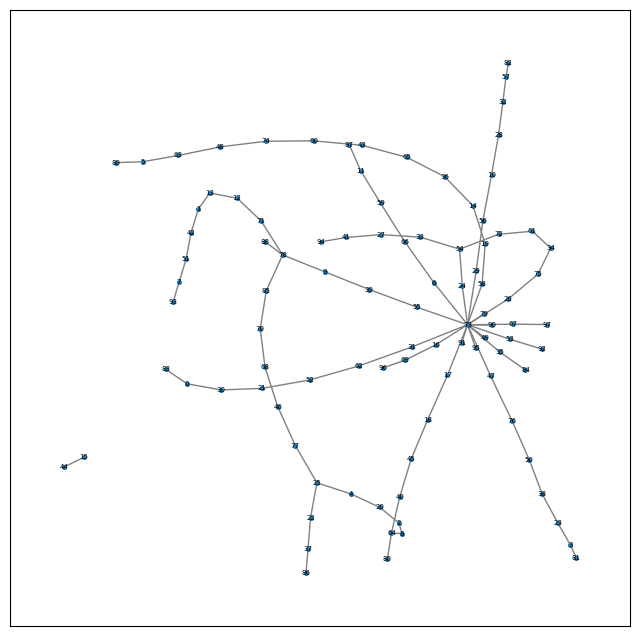

In [118]:
plt.figure(figsize=(8, 8))
ecg_graph = nx.from_pandas_edgelist(ecg_table, source = "subject_id", target = "report")
nx.draw_networkx(ecg_graph, pos=nx.spring_layout(ecg_graph), node_size=7, font_size = 5,edge_color ='grey')
#nx.draw_networkx(ecg_graph, pos=nx.circular_layout(ecg_graph), node_size=7,
#                 font_size = 7, edge_color ='grey')

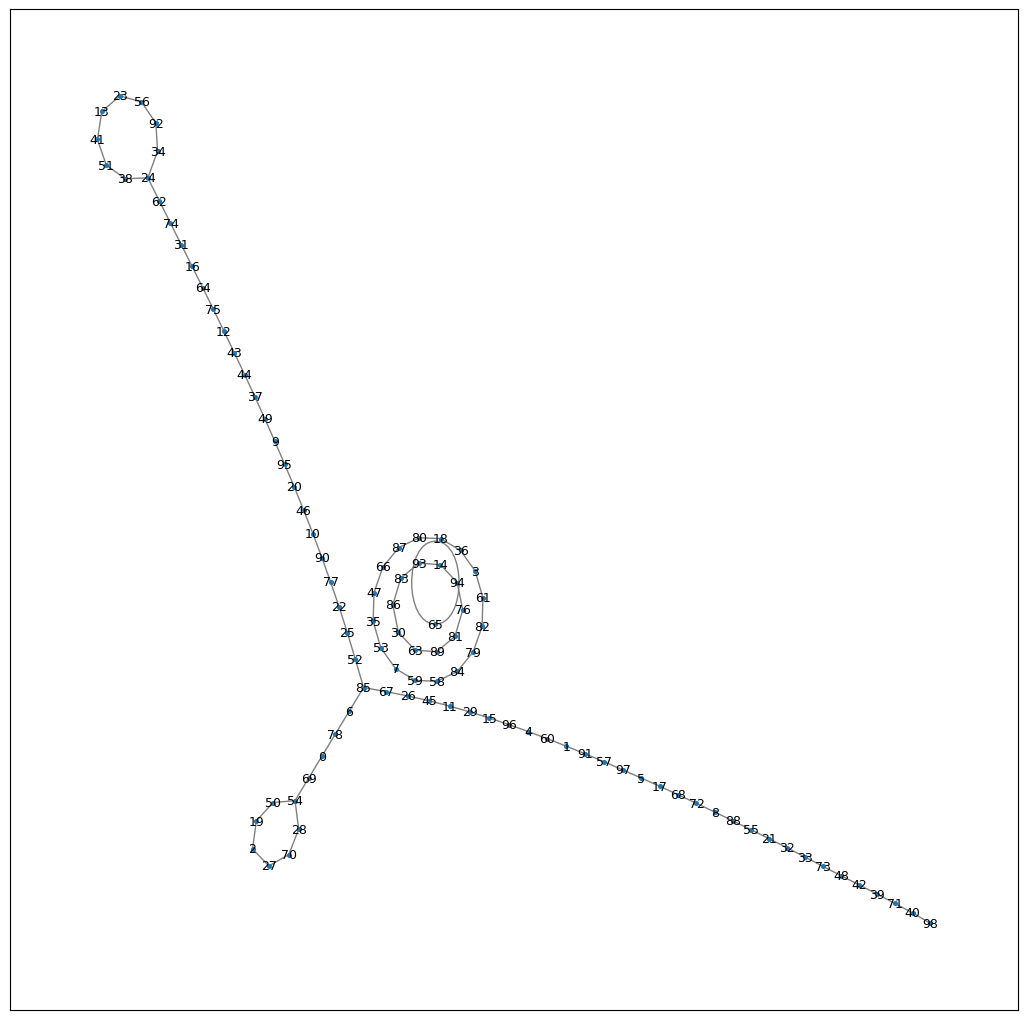

In [122]:
plt.figure(figsize=(13, 13))
# цвет - это диагноз - надо доработать и сделать там классы ограниченные
colors = ecg_table["Healthy_Status"].tolist()

# задаем матрицу смежности - здесь формируются ребра графа
ecg_graph = nx.from_pandas_edgelist(ecg_table, source = "eeg_date", target = "subject_id")


# subject - это диагноз, надо его привести к чему-то
subjects = list(ecg_table[ecg_table["subject_id"].isin(list(ecg_graph.nodes))]["Healthy_Status"])

#nx.draw_spring(ecg_graph, node_size=17, node_color=subjects)
nx.draw_networkx(ecg_graph,
                 #pos=nx.spring_layout(ecg_graph),
                 pos=nx.kamada_kawai_layout(ecg_graph, scale=5),
                 #pos=nx.planar_layout(ecg_graph),
                 #pos=nx.circular_layout(ecg_graph[, scale, center, dim])
                 node_size=7,
                 font_size = 9,
                 edge_color ='grey',
                 )#, node_color=subjects)

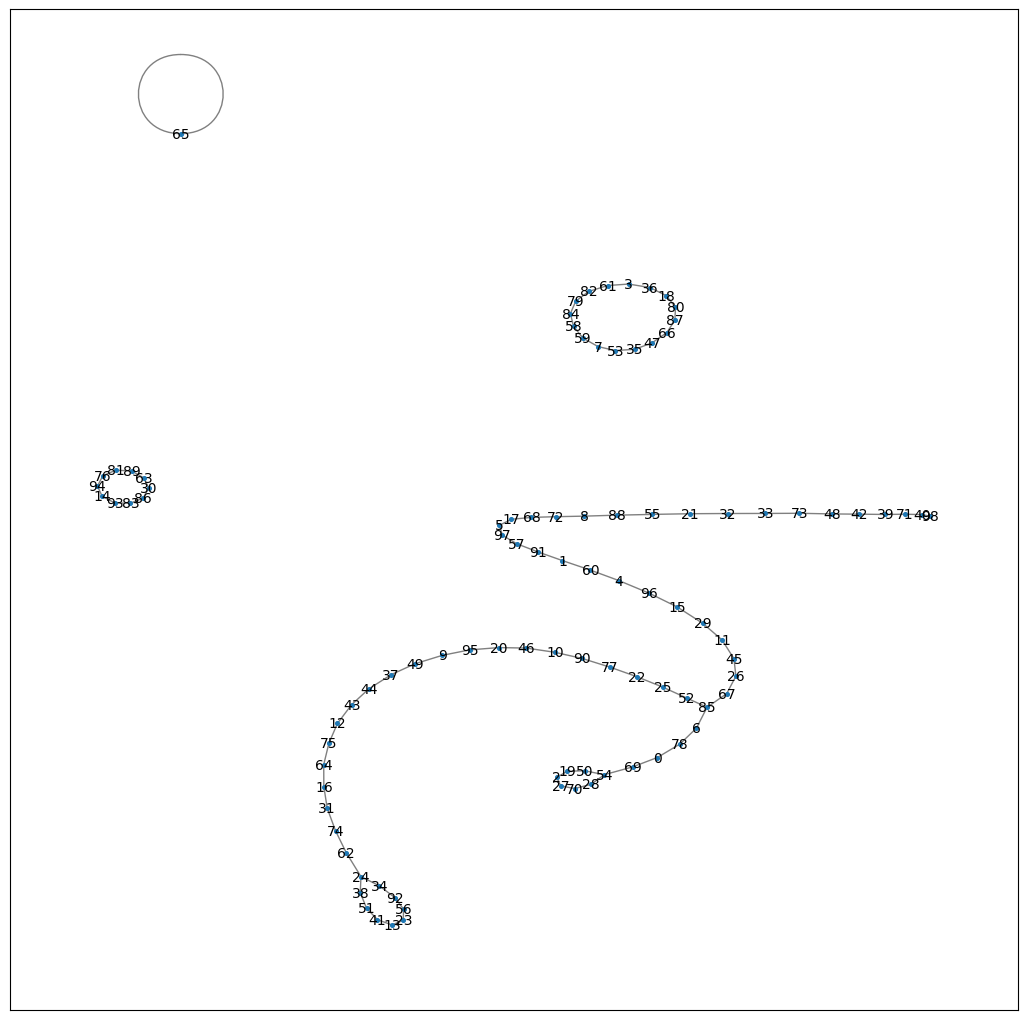

In [123]:
plt.figure(figsize=(13, 13))
# цвет - это диагноз - надо доработать и сделать там классы ограниченные
colors = ecg_table["Healthy_Status"].tolist()

# задаем матрицу смежности - здесь формируются ребра графа
ecg_graph = nx.from_pandas_edgelist(ecg_table, source = "eeg_date", target = "subject_id")


# subject - это диагноз, надо его привести к чему-то
subjects = list(ecg_table[ecg_table["subject_id"].isin(list(ecg_graph.nodes))]["Healthy_Status"])

#nx.draw_spring(ecg_graph, node_size=17, node_color=subjects)
nx.draw_networkx(ecg_graph,
                 #pos=nx.spring_layout(ecg_graph),
                 #pos=nx.kamada_kawai_layout(ecg_graph),
                 #pos=nx.planar_layout(ecg_graph),
                 #pos=nx.circular_layout(ecg_graph),
                 #pos=nx.arf_layout(ecg_graph),
                 #pos=nx.spectral_layout(ecg_graph),
                 #pos=nx.multipartite_layout(ecg_graph),
                 pos=nx.forceatlas2_layout(ecg_graph,scaling_ratio=3),
                 #pos=nx.shell_layout(ecg_graph, scale=1, center=None, dim=2),
                 node_size=7,
                 font_size = 10,
                 edge_color ='grey',
                 )#, node_color=subjects)

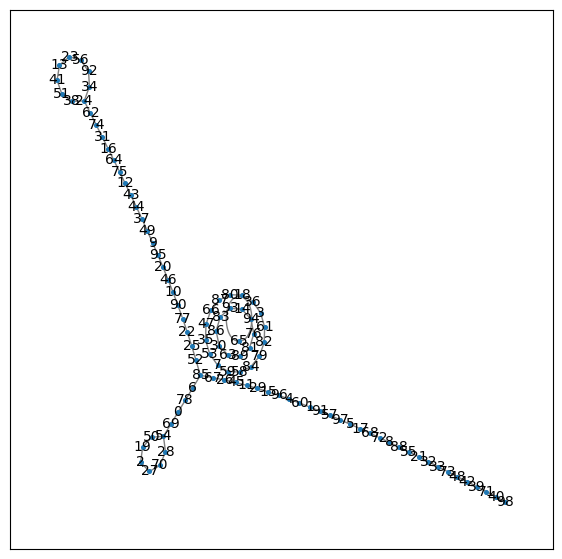

In [156]:
plt.figure(figsize=(7, 7))
# цвет - это диагноз - надо доработать и сделать там классы ограниченные
colors = ecg_table["Healthy_Status"].tolist()

# задаем матрицу смежности - здесь формируются ребра графа
ecg_graph = nx.from_pandas_edgelist(ecg_table, source = "eeg_date", target = "subject_id")


# subject - это диагноз, надо его привести к чему-то
subjects = list(ecg_table[ecg_table["subject_id"].isin(list(ecg_graph.nodes))]["Healthy_Status"])

#nx.draw_spring(ecg_graph, node_size=17, node_color=subjects)
nx.draw_networkx(ecg_graph,
                 #pos=nx.spring_layout(ecg_graph),
                 #pos=nx.spiral_layout(ecg_graph,scale=1),
                 pos=nx.kamada_kawai_layout(ecg_graph),
                 #pos=nx.planar_layout(ecg_graph),
                 #pos=nx.circular_layout(ecg_graph),
                 #pos=nx.arf_layout(ecg_graph),
                 #pos=nx.spectral_layout(ecg_graph),
                 #pos=nx.multipartite_layout(ecg_graph),
                 #pos=nx.forceatlas2_layout(ecg_graph,scaling_ratio=3),
                 #pos=nx.shell_layout(ecg_graph, scale=1, center=None, dim=2),
                 arrows=True,
                 with_labels=True,
                 node_size=7,
                 font_size = 10,
                 edge_color ='grey',
                 )#, node_color=subjects)

In [163]:
print(list(ecg_graph.nodes)[0])
list(ecg_graph.neighbors(list(ecg_graph.nodes)[5]))


78


[27, 19]

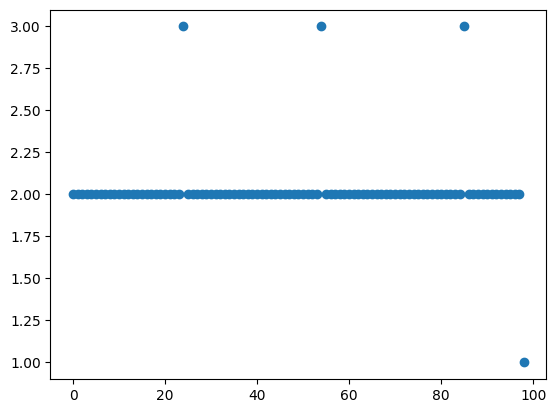

In [187]:
degrees = [(name, degree) for name, degree in ecg_graph.degree()]
degrees_arr = np.asarray(degrees, dtype=int)
degrees_arr = degrees_arr.T
plt.scatter(degrees_arr[0],degrees_arr[1])

In [188]:
#nx.clustering(ecg_graph)

{78: 0,
 0: 0,
 91: 0,
 1: 0,
 27: 0,
 2: 0,
 36: 0,
 3: 0,
 60: 0,
 4: 0,
 17: 0,
 5: 0,
 85: 0,
 6: 0,
 59: 0,
 7: 0,
 88: 0,
 8: 0,
 49: 0,
 9: 0,
 46: 0,
 10: 0,
 29: 0,
 11: 0,
 75: 0,
 12: 0,
 23: 0,
 13: 0,
 94: 0,
 14: 0,
 96: 0,
 15: 0,
 31: 0,
 16: 0,
 68: 0,
 80: 0,
 18: 0,
 19: 0,
 95: 0,
 20: 0,
 32: 0,
 21: 0,
 77: 0,
 22: 0,
 56: 0,
 38: 0,
 24: 0,
 25: 0,
 45: 0,
 26: 0,
 70: 0,
 54: 0,
 28: 0,
 86: 0,
 30: 0,
 74: 0,
 33: 0,
 73: 0,
 34: 0,
 53: 0,
 35: 0,
 44: 0,
 37: 0,
 51: 0,
 71: 0,
 39: 0,
 98: 0,
 40: 0,
 41: 0,
 42: 0,
 43: 0,
 47: 0,
 48: 0,
 50: 0,
 52: 0,
 69: 0,
 55: 0,
 92: 0,
 97: 0,
 57: 0,
 84: 0,
 58: 0,
 61: 0,
 62: 0,
 63: 0,
 64: 0,
 65: 0,
 66: 0,
 67: 0,
 72: 0,
 81: 0,
 76: 0,
 90: 0,
 82: 0,
 79: 0,
 87: 0,
 89: 0,
 93: 0,
 83: 0}

# working...

In [ ]:
feature_names = set(ecg_table.columns) - {"subject_id", "report"}


In [ ]:
edges = ecg_table[["eeg_time", "subject_id"]].to_numpy().T
print("Edges shape:", edges.shape)

KeyError: "['eeg_time'] not in index"

In [ ]:
edges

array([[17,  8,  1, 66, 71, 14, 97, 88,  7, 69, 29, 72, 25, 42, 62, 56,
        26, 47, 21, 70, 75, 90, 93, 44, 84, 11, 16, 80, 58, 87, 13, 91,
        37,  3, 52, 64, 51,  6, 33, 24, 86,  4, 99, 10, 55, 67, 60, 22,
        61, 19,  2, 23, 59, 95, 12, 15, 92, 73, 53, 39, 50,  0, 48, 98,
        68, 32, 31, 82, 89, 79, 65, 96, 38, 49, 28, 77, 83, 81, 45, 35,
        46, 74,  5,  9, 63, 36, 57, 43, 30, 27, 54, 85, 78, 40, 41, 94,
        18, 20, 76, 34],
       [ 5,  3, 47, 48, 16,  5, 78, 11, 28, 52, 65, 64, 56, 37, 68, 72,
        33, 10, 80, 26, 38, 42,  0, 45, 32,  5,  5, 18, 71,  0, 63,  0,
        59, 21, 43, 41, 13, 62, 12, 77, 14, 31, 19, 15, 24, 66, 70,  8,
        74, 53, 29, 58, 39,  0,  5, 86,  0, 49, 69, 72, 35, 55, 57, 30,
        46, 84,  1, 67,  0,  7, 22, 82,  6,  2, 40, 81, 17, 27,  9, 61,
        54, 73, 50, 23, 76, 25, 83, 59, 51, 40, 79, 44, 75, 85, 60, 20,
         4,  4, 34, 36]])

In [ ]:
node_features = tf.cast(ecg_table.sort_values("subject_id")[list(feature_names)].to_numpy(), dtype=tf.float32)
print("Nodes shape:", node_features.shape)


Nodes shape: (100, 31)


In [ ]:
edge_weights = tf.ones(shape=edges.shape[1])
print("Edges_weights shape:", edge_weights.shape)

Edges_weights shape: (100,)


In [ ]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
         # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)


In [ ]:
"""
### Implement a graph convolution layer

We implement a graph convolution module as a [Keras Layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer?version=nightly).
Our `GraphConvLayer` performs the following steps:

1. **Prepare**: The input node representations are processed using a FFN to produce a *message*. You can simplify
the processing by only applying linear transformation to the representations.
2. **Aggregate**: The messages of the neighbours of each node are aggregated with
respect to the `edge_weights` using a *permutation invariant* pooling operation, such as *sum*, *mean*, and *max*,
to prepare a single aggregated message for each node. See, for example, [tf.math.unsorted_segment_sum](https://www.tensorflow.org/api_docs/python/tf/math/unsorted_segment_sum)
APIs used to aggregate neighbour messages.
3. **Update**: The `node_repesentations` and `aggregated_messages`—both of shape `[num_nodes, representation_dim]`—
are combined and processed to produce the new state of the node representations (node embeddings).
If `combination_type` is `gru`, the `node_repesentations` and `aggregated_messages` are stacked to create a sequence,
then processed by a GRU layer. Otherwise, the `node_repesentations` and `aggregated_messages` are added
or concatenated, then processed using a FFN.


The technique implemented use ideas from [Graph Convolutional Networks](https://arxiv.org/abs/1609.02907),
[GraphSage](https://arxiv.org/abs/1706.02216), [Graph Isomorphism Network](https://arxiv.org/abs/1810.00826),
[Simple Graph Networks](https://arxiv.org/abs/1902.07153), and
[Gated Graph Sequence Neural Networks](https://arxiv.org/abs/1511.05493).
Two other key techniques that are not covered are [Graph Attention Networks](https://arxiv.org/abs/1710.10903)
and [Message Passing Neural Networks](https://arxiv.org/abs/1704.01212).
"""
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_repesentations):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        # node_repesentations shape is [num_nodes, representation_dim]
        num_nodes = node_repesentations.shape[0]
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")
        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(
            node_indices, neighbour_messages, node_repesentations
        )
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)

In [ ]:
graph_info = (node_features, edges, edge_weights)

In [ ]:
num_classes = len(class_idc)

In [ ]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

In [ ]:
hidden_units = [64, 64]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)
#gnn_model.summary()

In [ ]:
train_data, test_data = [], []

for _, group_data in ecg_table.groupby("report_0"):
    # Select around 50% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.5
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (58, 33)
Test data shape: (42, 33)


In [ ]:
x_train = train_data.study_id.to_numpy()
y_train = train_data["report_0"]

In [ ]:
x_test = test_data.study_id.to_numpy()
y_test = test_data["report_0"]

In [ ]:
def run_experiment(model, x_train, y_train, x_test, y_test):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=100, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(58,)
(58,)
(42,)
(42,)


In [ ]:
history = run_experiment(gnn_model, x_train, y_train, x_test, y_test)

Epoch 1/300
1/1 [==============================] - 10s 10s/step - loss: 3.9810 - acc: 0.0000e+00 - val_loss: 28.8400 - val_acc: 0.0000e+00
Epoch 2/300
1/1 [==============================] - 0s 66ms/step - loss: 3.9139 - acc: 0.0408 - val_loss: 20.1806 - val_acc: 0.0000e+00
Epoch 3/300
1/1 [==============================] - 0s 66ms/step - loss: 3.3638 - acc: 0.1224 - val_loss: 17.1173 - val_acc: 0.0000e+00
Epoch 4/300
1/1 [==============================] - 0s 49ms/step - loss: 3.1318 - acc: 0.0816 - val_loss: 16.7514 - val_acc: 0.0000e+00
Epoch 5/300
1/1 [==============================] - 0s 73ms/step - loss: 2.9210 - acc: 0.2449 - val_loss: 16.3380 - val_acc: 0.0000e+00
Epoch 6/300
1/1 [==============================] - 0s 55ms/step - loss: 2.7871 - acc: 0.2653 - val_loss: 16.6744 - val_acc: 0.2222
Epoch 7/300
1/1 [==============================] - 0s 48ms/step - loss: 2.5225 - acc: 0.3673 - val_loss: 17.7429 - val_acc: 0.2222
Epoch 8/300
1/1 [==============================] - 0s 71ms/

Text(0, 0.5, 'Loss')

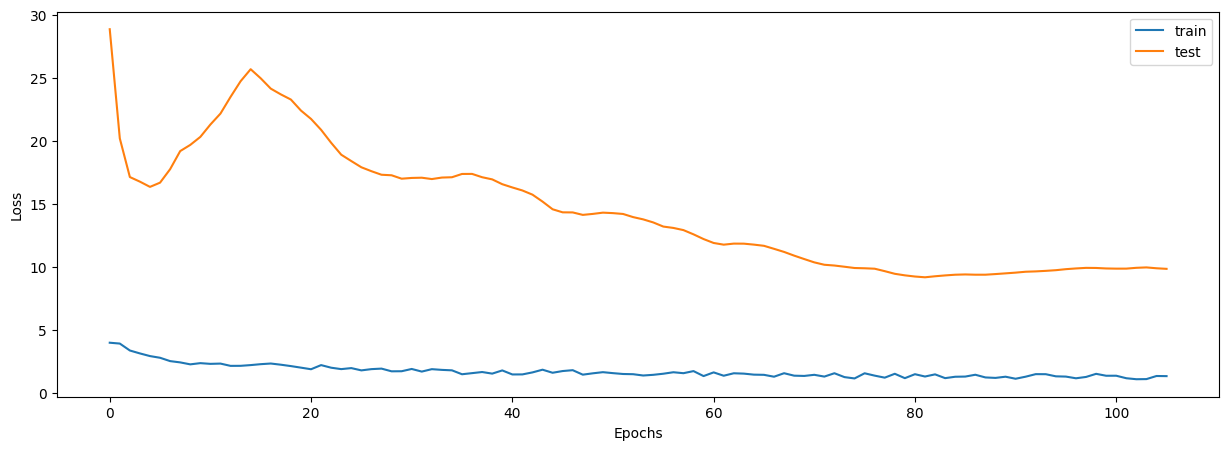

In [ ]:

fig, ax1 = plt.subplots(1, figsize=(15, 5))

ax1.plot(history.history["loss"])
ax1.plot(history.history["val_loss"])
ax1.legend(["train", "test"], loc="upper right")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

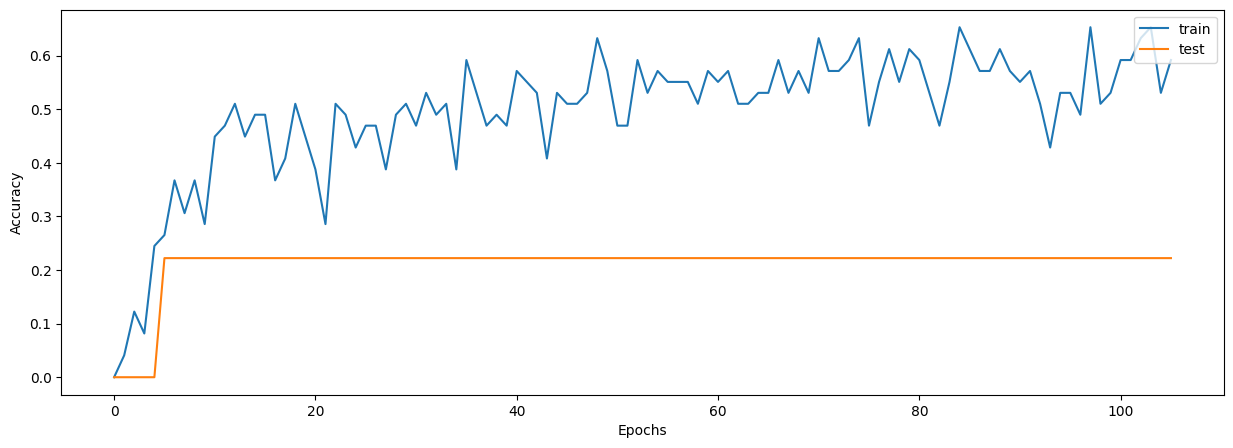

In [ ]:
fig, ax2 = plt.subplots(1, figsize=(15, 5))
ax2.plot(history.history["acc"])
ax2.plot(history.history["val_acc"])
ax2.legend(["train", "test"], loc="upper right")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
plt.show()